In [1]:
import sys
import os
here = os.getcwd()
sys.path.append(os.path.join(here,"../../"))

In [2]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree,export_text,export_graphviz
from sklearn.model_selection import train_test_split

In [3]:
from amore.explainer.itemsets_miner import *
import amore.explainer.rule_pattern_miner as rlm
import amore.explainer.DT_rules as dtr
from amore.explainer.explainer_utils import *
import amore.explainer.RuleGrowth_tree as rgtree


In [4]:
def encode_one_hot(df,col_name):
    df[col_name] = pd.Categorical(df[col_name])
    one_hot = pd.get_dummies(df[col_name])
    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(col_name,axis=1)
    return df

def min_max_normalization(df,col_name,min_val=None,max_val=None):
    if min_val is None:
        min_val = df[col_name].min()
    if max_val is None:
        max_val = df[col_name].max()
    df[col_name] = (df[col_name]-min_val)/(max_val-min_val)
    return df

def min_max_multicols(df,col_names,min_max_df=None):
    if min_max_df is None:
        min_max_df = pd.DataFrame(columns=col_names)
        min_max_df.loc["min"] = df.loc[:,min_max_df.columns].min(axis=0)
        min_max_df.loc["max"] = df.loc[:,min_max_df.columns].max(axis=0)
    for cn in col_names:
        df = min_max_normalization(df,cn,min_max_df.loc["min",cn],min_max_df.loc["max",cn])
    return df, min_max_df

def recover_feature_raw_value(fid,fval,featur_names,raw_min_max,ntype="min_max"):
    fn = featur_names[fid]
    if ntype == "min_max":
        if fn in raw_min_max.columns:
            mx = raw_min_max.loc[:,fn].max()
            mi = raw_min_max.loc[:,fn].min()
            return fval*(mx-mi)+mi
        return fval
    else:
        raise TypeError("Not yet supported type")

# Download/load and preprocess data
### The dataset can be downloaded from https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

In [5]:
## control random seed for reproducibility
seed = 42
np.random.seed(seed)

## set where to load data
dpath = "./data/diabetes_prediction_dataset.csv"

## set results path to save results
rpath = "./results"

## read diabetes dataset
# df = pd.read_csv(dpath,header=1)
df = pd.read_csv(dpath)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [6]:
## transform categorical feature to one-hot-encoder
df = encode_one_hot(df,'gender')
df = encode_one_hot(df,'smoking_history')
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,Female,Male,Other,No Info,current,ever,former,never,not current
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,1,0,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,1,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,0,1,0,0,0,0


In [7]:
## split training and test set
X_train,X_test,y_train,y_test = train_test_split(df.drop('diabetes',axis=1),df['diabetes'],test_size=0.3,random_state=seed)

## min-max normalize numerical features
X_train,min_max = min_max_multicols(X_train,col_names=['age','bmi','HbA1c_level','blood_glucose_level'])
X_test,_ = min_max_multicols(X_test,col_names=min_max.columns,min_max_df=min_max)

In [8]:
## specify feature types
feature_types = []
for c in X_train.columns:
    if np.dtype(X_train[c])!=np.uint8:
        feature_types.append(str(np.dtype(X_train[c])))
    else:
        feature_types.append("cat")
    print(c,np.dtype(X_train[c]),feature_types[-1])

age float64 float64
hypertension int64 int64
heart_disease int64 int64
bmi float64 float64
HbA1c_level float64 float64
blood_glucose_level float64 float64
Female uint8 cat
Male uint8 cat
Other uint8 cat
No Info uint8 cat
current uint8 cat
ever uint8 cat
former uint8 cat
never uint8 cat
not current uint8 cat


In [9]:
## apply oversampling on training set 

from imblearn.over_sampling import SMOTE

oversampler = SMOTE(random_state=seed)
X_over, y_over = oversampler.fit_resample(X_train, y_train)

## Train logistic regression model

In [10]:
## train a logistic regression model and check performance on test set
log_reg = LogisticRegression(max_iter=2000,multi_class='ovr',random_state=seed)
log_reg.fit(X_over,y_over)
y_pred = log_reg.predict(X_test)


accuracy = log_reg.score(X_test,y_test)
confusion = confusion_matrix(y_test,y_pred)
precision = precision_score(y_test,y_pred,average=None)
recall = recall_score(y_test,y_pred,average=None)
accuracy,confusion,precision,recall

(0.8882666666666666,
 array([[24405,  3048],
        [  304,  2243]]),
 array([0.98769679, 0.42392742]),
 array([0.88897388, 0.88064389]))

auc 0.9621384460095029
y threshold 0.4571048952150361


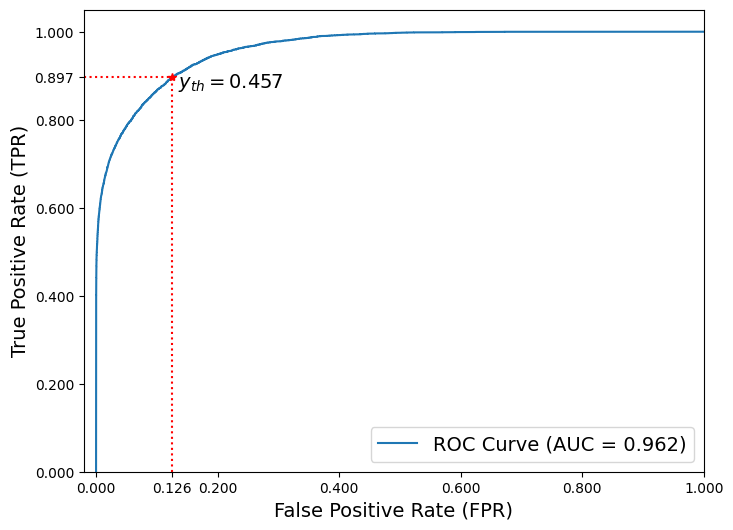

In [11]:
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt
# import scipy as sp

## find and plot the prediction threshold using ROC

pred_y = log_reg.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, pred_y)
print("auc",auc)

fpr, tpr, thresholds = roc_curve(y_train, pred_y)
th_id = np.argmax(tpr - fpr)
y_thd = thresholds[th_id]
print("y threshold",y_thd)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot(fpr[th_id],tpr[th_id],"r*")
plt.annotate('$y_{th}=$'+str(y_thd.round(3)), (fpr[th_id],tpr[th_id]), textcoords='offset points', xytext=(42,-8), ha='center',fontsize=14)

plt.plot([fpr[th_id],fpr[th_id]],[0,tpr[th_id]],"r:")
plt.plot([-0.02,fpr[th_id]],[tpr[th_id],tpr[th_id]],"r:")
plt.xlim(-0.02,1.)
plt.xticks([0.,fpr[th_id],0.2,0.4,0.6,0.8,1.])
plt.yticks([0.,0.2,0.4,0.6,0.8,tpr[th_id],1.])
plt.ylim(0,1.05)
plt.xlabel('False Positive Rate (FPR)',fontsize=14)
plt.ylabel('True Positive Rate (TPR)',fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("./results/roc.eps",bbox_inches="tight")

plt.show()

In [12]:
## check AUC on test set
pred_y_test = log_reg.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, pred_y_test)
auc

0.962387678432344

## Feature selection for rule extraction

In [13]:
## get baseline samples and test samples for computing impact scores of features

baselines = gen_intgrad_baselines(X_over.values,y_over.values)
subset = gen_balanced_subset(X_train.values,y_train.values,size_per_class=int(y_train.sum()))

In [14]:
## compute impact score matrix

C=2
baseline_output = log_reg.predict_proba(baselines)[:,1]
subset_output,yshift,int_g = [],[],[]    
cids = np.arange(C)
for k in cids:    
    subset_output.append(log_reg.predict_proba(subset[k])[:,1])
    for kk in cids[cids!=k]:
        yshift.append(subset_output[k]-baseline_output[kk])
        int_g.append((subset[k]-baselines[kk])* log_reg.coef_)
yshift = np.concatenate(yshift)
int_g = np.vstack(int_g)
y_int_g = np.abs(int_g)/yshift.reshape(-1,1)

In [15]:
## find threshold for impact score

thds = np.linspace(0.01,1.,1000)
f_n = []
for thd in thds:
    mask = np.abs(y_int_g) >= thd 
    f_n.append((thd,(mask.sum(axis=0)>=len(y_int_g)*0.99).sum()))
#     print(f_n[-1])
    if f_n[-1][1]==1:
        break
thd = f_n[-1][0]
thd

0.2527927927927928

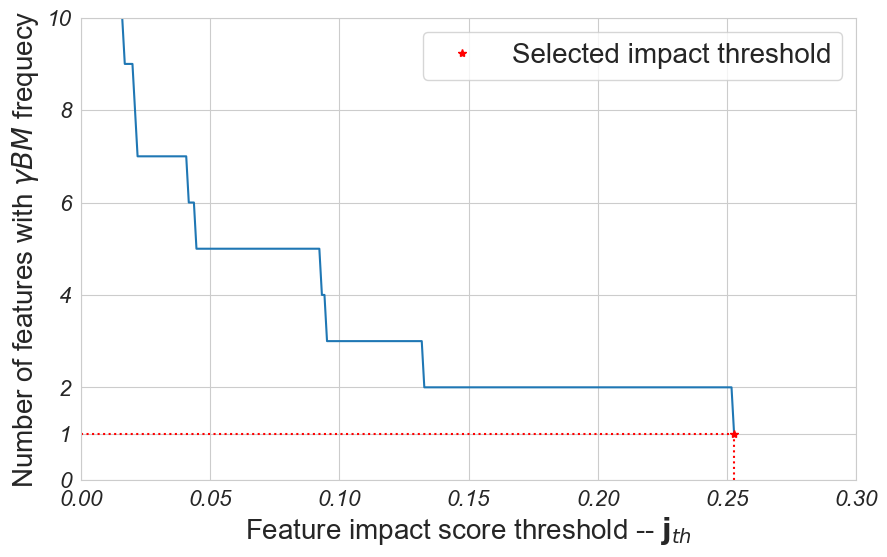

In [16]:
## plot the scanning process of finding threshold

import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot([th[0] for th in f_n[:]],[(th[1]) for th in f_n[:]])
plt.plot(f_n[-1][0],(f_n[-1][1]),"r*",label="Selected impact threshold")
plt.plot([0,f_n[-1][0]],[(f_n[-1][1]),(f_n[-1][1])],":r")
plt.plot([f_n[-1][0],f_n[-1][0]],[0,f_n[-1][1]],":r")
plt.xlim(0.,.3)
plt.ylim(0.,10)
plt.yticks([0,1,2,4,6,8,10],fontsize=16,fontstyle='italic')
plt.xticks(fontsize=16,fontstyle='italic')
plt.xlabel(r"Feature impact score threshold -- $\mathbf{j}_{th}$",fontsize=20)
plt.ylabel(r"Number of features with $\gamma BM$ frequecy",fontsize=20)
plt.legend(fontsize=20)
# plt.savefig("./results/score_thd.svg",bbox_inches="tight")

In [17]:
## identify frequent important feature set

itemsets_y = transform_intgrad_to_itemsets(y_int_g,thd=thd)
fids = gen_freq_feature_set(itemsets_y[0],min_support=500,max_len=100)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

feature set [4 7 0 5 3 9 1 6 2] 9


## Rule extraction by AMORE 

In [18]:
## set "grid_search = True" to do a grid search for hyperprameters

grid_search = True

if grid_search:
    ng_range = np.arange(2,11)
    bin_strategies = ["uniform","kmeans"]
    support_range = np.arange(1000,6000,1000)
    confidence_lower_bound = 0.8
    max_depth=1
    top_K=3


    best_rule_set,best_configs,config_metric_records = rlm.param_grid_search_for_amore(bin_strategies,ng_range,support_range,X_train.values,fids,target_indices=pred_y>y_thd,y=y_train.values,c=1,confidence_lower_bound = confidence_lower_bound,
                                                                                        max_depth=max_depth,top_K=top_K,sort_by="fitness")
    print(best_rule_set,best_configs)

grid search hyperparameters
{'rules': [(4, '>=', 0.5714285714285714)], 'confidence': 0.993421052631579, 'support': 2736, 'fitness': 0.20180880484341132, 'cond_prob_y': 1.0, 'ratio_y': 0.4596002015790358} {'bin_strategy': 'uniform', 'num_grids': 7, 'min_support': 2000}


In [19]:
### search rules for target pattern: pred_y > y_thd  ###
### we set the hyperparameters obtaind by above grid search step ###

min_support=2000
bin_strategy="uniform"
num_grids=7
max_depth=1
top_K=3

y_rule_candidates = rlm.gen_rule_list_for_one_target(X_train.values,fids,pred_y>y_thd,y=y_train.values,c=1,sort_by="fitness",
                                                    min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=top_K,
                                                    local_x=None,feature_types=feature_types,bin_strategy=bin_strategy,
                                                    verbose=False)

for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],X_train.columns)
    y_rule_candidates[i] = rules
y_rule_candidates[0]

{'rules': [(4, 'HbA1c_level', '>=', 0.5714285714285714)],
 'confidence': 0.993421052631579,
 'support': 2736,
 'fitness': 0.20180880484341132,
 'cond_prob_y': 1.0,
 'ratio_y': 0.4596002015790358}

In [20]:
## recover raw feature value by reversing the min-max normalization

for n in range(len(y_rule_candidates)):
    for i, r in enumerate(y_rule_candidates[n]["rules"]):
        nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
        y_rule_candidates[n]["rules"][i] = (*r[:-1],nr) 
        print(y_rule_candidates[n])

{'rules': [(4, 'HbA1c_level', '>=', 6.642857142857142)], 'confidence': 0.993421052631579, 'support': 2736, 'fitness': 0.20180880484341132, 'cond_prob_y': 1.0, 'ratio_y': 0.4596002015790358}
{'rules': [(5, 'blood_glucose_level', '>=', 205.71428571428572)], 'confidence': 0.9978326831382748, 'support': 2307, 'fitness': 0.17168697212048734, 'cond_prob_y': 1.0, 'ratio_y': 0.3875356962875861}
{'rules': [(2, 'heart_disease', '==', 1.0)], 'confidence': 0.5977052707063464, 'support': 2789, 'fitness': 0.040735480977651554, 'cond_prob_y': 0.3209035496593761, 'ratio_y': 0.15034436418612465}


## Rule extraction by DT Classifier 

In [21]:
## set "grid_search = True" to do a grid search for hyperprameters

if grid_search:
    criteria = ["gini", "entropy", "log_loss"]
    w = (y_train==c).sum()/y_train.shape[0]
    class_weight_options = [{0:0.5,1:0.5},{0:1./(1.-w),1:1./w}]
    support_range = np.arange(1000,6000,1000)
    confidence_lower_bound = 0.
    max_depth=1
    DT_best_rule_set, DT_best_configs, DT_config_metric_records = dtr.param_grid_search_for_DT(criteria,support_range,weight_options=class_weight_options,X=X_train.values,y=y_train.values,target_indices=pred_y>y_thd,c=1,max_depth=max_depth,feature_names=X_train.columns,confidence_lower_bound=confidence_lower_bound,seed=seed)
    print(DT_best_rule_set, DT_best_configs)


{'rules': [(4, '>', 0.518)], 'support': 14501, 'fitness': 0.03266312878391509, 'confidence': 0.515067926349907} {'criterion': 'gini', 'min_support': 1000, 'class_weight': {0: 0.5, 1: 0.5}}


In [22]:
### Obtain rules for target pattern: pred_y > y_thd from a DecisionTreeClassifier ###
### We set the hyperparameters obtaind by above grid search step ###
criterion="gini"
min_support=1000
class_weight={0: 0.5, 1: 0.5}

input_feature_names =X_train.columns
treemodel = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_support,criterion=criterion,random_state=seed,class_weight=class_weight)
treemodel.fit(X_train,pred_y>y_thd)
rule_list, rule_value_list, rule_metric_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,X_train.values,y_train.values,pred_y>y_thd,np.arange(X_train.shape[-1]),X_train.columns,c=1)
print(export_text(treemodel))

|--- feature_4 <= 0.52
|   |--- class: False
|--- feature_4 >  0.52
|   |--- class: True



In [23]:
## recover raw feature value by reversing the min-max normalization
for s in range(len(rule_list)):
    for j, r in enumerate(rule_list[s]):
        nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
        rule_list[s][j] = (*r[:-1],nr)

In [24]:
## display rules extracted by DT classifier
dtr.display_rules_from_DT(rule_list,rule_metric_list,input_feature_names)

#################
[(4, '<=', 6.349)]
confidence 0.106 cond_prob_y 0.042 support 55499 fitness -3.265
HbA1c_level <= 6.349
#################
[(4, '>', 6.349)]
confidence 0.515 cond_prob_y 0.251 support 14501 fitness 0.033
HbA1c_level > 6.349


## Extract local rules for specific test samples by AMORE

In [25]:
## tids of test samples demonstrated in the paper: 5,4,144

tid = 144
x = X_train.values
xi = X_test.values[tid,:]
pred_y_test[tid],y_test.values[tid]

(0.42439205526547025, 1)

In [26]:
ng_range = np.arange(2,11)
bin_strategies = ["uniform","kmeans"]
support_range = [1000]
confidence_lower_bound = 0.8
max_depth=3
top_K=3

local_best_rule_set,local_best_configs,local_config_metric_records = rlm.param_grid_search_for_amore(bin_strategies,ng_range,support_range,X_train.values,fids,target_indices=pred_y>y_thd,y=y_train.values,c=1,confidence_lower_bound = confidence_lower_bound,
                                                                                        max_depth=max_depth,top_K=top_K,sort_by="confidence",local_x=xi,feature_types=feature_types)



grid search hyperparameters


In [27]:
local_best_rule_set,local_best_configs

({'rules': [(3, '>=', 0.3357801811640126),
   (4, '>=', 0.3186770667450987),
   (0, '>=', 0.6823256580015833)],
  'confidence': 0.8925373134328358,
  'support': 1340,
  'fitness': 0.07863068988713656,
  'cond_prob_y': 0.5417910447761194,
  'ratio_y': 0.1219553166470687},
 {'bin_strategy': 'kmeans', 'num_grids': 3, 'min_support': 1000})

In [28]:
## display the top local rule set

rules = local_best_rule_set
rules["rules"] = rlm.replace_feature_names(rules["rules"],X_train.columns)
for i, r in enumerate(rules["rules"]):
    nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
    rules["rules"][i] = (*r[:-1],nr) 
rules

{'rules': [(3, 'bmi', '>=', 37.480176621027866),
  (4, 'HbA1c_level', '>=', 5.252723867098043),
  (0, 'age', '>=', 54.61146658748654)],
 'confidence': 0.8925373134328358,
 'support': 1340,
 'fitness': 0.07863068988713656,
 'cond_prob_y': 0.5417910447761194,
 'ratio_y': 0.1219553166470687}

### Below code is for plotting confidence and fitness while varying minimum support¶

In [29]:
import amore.explainer.explainer_utils as eutils

In [30]:
confidence_lower_bound = 0.9
confidence_lower_bound

0.9

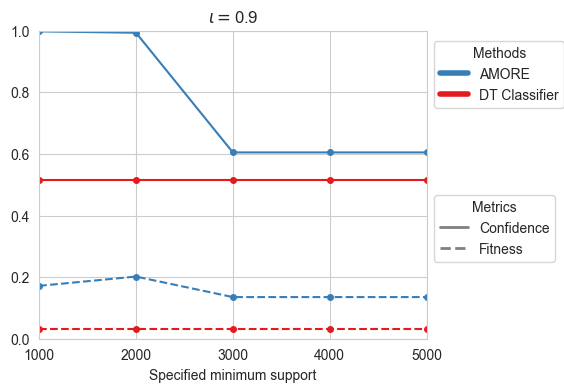

In [31]:
if grid_search:
    keys = list(DT_config_metric_records.keys())
    for key in keys:
        if len(DT_config_metric_records[key]["top_confidence_records"]) ==0:
            del DT_config_metric_records[key]
    
    cf_mtx = np.vstack([config_metric_records[key]["top_confidence_records"] for key in config_metric_records.keys()])
    ft_mtx = np.vstack([config_metric_records[key]["top_fitness_records"] for key in config_metric_records.keys()])
    
    DT_cf_mtx = np.vstack([DT_config_metric_records[key]["top_confidence_records"] for key in DT_config_metric_records.keys()])
    DT_ft_mtx = np.vstack([DT_config_metric_records[key]["top_fitness_records"] for key in DT_config_metric_records.keys()])
    
    support_range = np.arange(1000,6000,1000)
    eutils.plot_confidence_fitness_curve(cf_mtx,ft_mtx,DT_cf_mtx,DT_ft_mtx,support_range,confidence_lower_bound=confidence_lower_bound)